# **Finding Lane Lines on the Road** 
***
The aim of this project is to create a pipeline taking images or videos as an input and produce an anotated output where lane lines are identified.  

## 1 - Pipeline
The pipeline takes as an input a colored image and outputs the same image where detected lane lines are annotated.  
In order to that, the input image is passed through several tranformations. It is (in order):
- converted to grayscale
- smoothed (using Gaussian Kernel)
- edge are detected using Canny algorithm
- a mask is applied so that only a part of the image is considered
- lines are detected using the Hough transform
- only lines whose slope are between some given boundaries are considered.  
We then have a group of lines belonging to the left lane and another one belonging to the right lane
- detected lines are then averaged so that we get the average slope of the left and right lane lines
- given the slope we consider lane lines going from the bottom of the picture up to 2/5th of the picture
- we average the detected lines with the ones from the previous image to reduce noise and be sure that a line is always detected.  
This part acts as a 'memory' of previously found lane lines and will prove to be particularly helpful on the Challenge video where road and light conditions are changing

All parameters of the above pipeline are stored in the global Python dictionary 'parameters'

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2
import os
%matplotlib inline

global parameters
parameters = \
    {
        # convert to grayscale
        'grayscale': True,
        # smoothing
        'smoothing': True,
        'kernel_size': 5,
        # Canny
        'canny': True,
        'low_threshold': 50,
        'high_threshold': 200,
        # (normalized) RoI mask vertices
        'mask': True,
        'norm_vertices': np.array([[(0.025, 1), (0.975, 1), (0.51, 0.55), (0.49, 0.55)]]),
        # Hough transform parameters
        'hough': True,
        'rho': 1,
        'theta': 1*np.pi / 180,
        'threshold': 50,
        'min_line_len': 200,
        'max_line_gap': 200,
        # lines slopes acceptable values (min and max for right and left lane lines)
        'min_left': -1.,
        'max_left': -0.5,
        'min_right': 0.2,
        'max_right': 1.,
        # time memory (previous lane lines are averaged with current one and this weight is applied)
        'memory': 0.5
}


global lanes
lanes = \
    {
    'left': {'x1': 0., 'y1': 0., 'x2': 0., 'y2': 0.},
    'right': {'x1': 0., 'y1': 0., 'x2': 0., 'y2': 0.}
    }


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_lane_lines = []
    right_lane_lines = []
    # separates lines between left and right lanes and exclude other ones (horizontal lines for example)
    # this is done by calculating the slope of each line and then checking if it is in an acceptable range
    for line in lines:
        for x1, y1, x2, y2 in line:
            # makes sure that (x1, y1) is the lower point (so the highest value here)
            if y1 < y2:
                temp = y1
                y1 = y2
                y2 = temp
                temp = x1
                x1 = x2
                x2 = temp
            slope = (y2-y1)/float(x2-x1)
            # if it is okay then it is considered as being a line of the left lane
            if parameters['min_left'] <= slope <= parameters['max_left']:
                left_lane_lines.append((x1, y1, x2, y2))
            # same here for right lane
            elif parameters['min_right'] <= slope <= parameters['max_right']:
                right_lane_lines.append((x1, y1, x2, y2))
    # calulate an average for each (right and left) lane
    memory = parameters['memory']
    n_left_lines = len(left_lane_lines)
    if n_left_lines > 0:
        left_x1 = sum(x[0] for x in left_lane_lines) / float(n_left_lines)
        left_y1 = sum(x[1] for x in left_lane_lines) / float(n_left_lines)
        left_x2 = sum(x[2] for x in left_lane_lines) / float(n_left_lines)
        left_y2 = sum(x[3] for x in left_lane_lines) / float(n_left_lines)
        left_slope = (left_y2-left_y1)/float(left_x2-left_x1)
        left_intercept = left_y1 - left_slope * left_x1
        # now makes sure that line starts at the bottom up to 1-3/5th of the screen
        left_y1 = img.shape[0]
        left_x1 = (left_y1 - left_intercept) / left_slope
        left_y2 = img.shape[0] * (3 / 5.)
        left_x2 = (left_y2 - left_intercept) / left_slope
        # averages result with previous line
        if (lanes['left']['x1']+lanes['left']['y1']+lanes['left']['x2']+lanes['left']['y2'] > 0):
            lanes['left']['x1'] = int((1-memory) * left_x1 + memory * lanes['left']['x1'])
            lanes['left']['y1'] = int((1-memory) * left_y1 + memory * lanes['left']['y1'])
            lanes['left']['x2'] = int((1-memory) * left_x2 + memory * lanes['left']['x2'])
            lanes['left']['y2'] = int((1-memory) * left_y2 + memory * lanes['left']['y2'])
        else:
            lanes['left']['x1'] = int(left_x1)
            lanes['left']['y1'] = int(left_y1)
            lanes['left']['x2'] = int(left_x2)
            lanes['left']['y2'] = int(left_y2)
        cv2.line(img, (lanes['left']['x1'], lanes['left']['y1']), (lanes['left']['x2'], lanes['left']['y2']),
                 color, thickness)
    else:
        if memory > 0 and (lanes['left']['x1']+lanes['left']['y1']+lanes['left']['x2']+lanes['left']['y2'] > 0):
            cv2.line(img, (lanes['left']['x1'], lanes['left']['y1']), (lanes['left']['x2'], lanes['left']['y2']),
                     color, thickness)
    # same thing for the right lane
    n_right_lines = len(right_lane_lines)
    if n_right_lines > 0:
        right_x1 = sum(x[0] for x in right_lane_lines) / float(n_right_lines)
        right_y1 = sum(x[1] for x in right_lane_lines) / float(n_right_lines)
        right_x2 = sum(x[2] for x in right_lane_lines) / float(n_right_lines)
        right_y2 = sum(x[3] for x in right_lane_lines) / float(n_right_lines)
        right_slope = (right_y2-right_y1)/float(right_x2-right_x1)
        right_intercept = right_y1 - right_slope * right_x1
        right_y1 = img.shape[0]
        right_x1 = (right_y1 - right_intercept) / right_slope
        right_y2 = img.shape[0] * (3 / 5.)
        right_x2 = (right_y2 - right_intercept) / right_slope
        if (lanes['right']['x1']+lanes['right']['y1']+lanes['right']['x2']+lanes['right']['y2'] > 0):
            lanes['right']['x1'] = int((1 - memory) * right_x1 + memory * lanes['right']['x1'])
            lanes['right']['y1'] = int((1 - memory) * right_y1 + memory * lanes['right']['y1'])
            lanes['right']['x2'] = int((1 - memory) * right_x2 + memory * lanes['right']['x2'])
            lanes['right']['y2'] = int((1 - memory) * right_y2 + memory * lanes['right']['y2'])
        else:
            lanes['right']['x1'] = int(right_x1)
            lanes['right']['y1'] = int(right_y1)
            lanes['right']['x2'] = int(right_x2)
            lanes['right']['y2'] = int(right_y2)
        cv2.line(img, (lanes['right']['x1'], lanes['right']['y1']), (lanes['right']['x2'], lanes['right']['y2']),
                 color, thickness)
    else:
        if memory > 0 and (lanes['right']['x1']+lanes['right']['y1']+lanes['right']['x2']+lanes['right']['y2'] > 0):
            cv2.line(img, (lanes['right']['x1'], lanes['right']['y1']), (lanes['right']['x2'], lanes['right']['y2']),
                     color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if lines is not None:
        draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, alpha_=0.8, beta_=1., lambda_=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, alpha_, img, beta_, lambda_)


def process_image(image):
    global parameters
    # reading in an image
    modified_image = image.copy()
    # to grayscale
    if parameters['grayscale']:
        modified_image = grayscale(modified_image)
    # gaussian smoothing
    if parameters['smoothing']:
        modified_image = gaussian_blur(modified_image, parameters['kernel_size'])
    # Canny edge detection
    if parameters['canny']:
        modified_image = canny(modified_image, parameters['low_threshold'], parameters['high_threshold'])
    # region of interest
    if parameters['mask']:
        norm_vertices = parameters['norm_vertices'].copy()
        norm_vertices[:, :, 0] *= modified_image.shape[1]
        norm_vertices[:, :, 1] *= modified_image.shape[0]
        vertices = norm_vertices.astype(int)
        modified_image = region_of_interest(modified_image, vertices)
    # Hough transform (returns a 3-D image)
    if parameters['hough']:
        modified_image = hough_lines(modified_image, parameters['rho'], parameters['theta'], parameters['threshold'],
                                     parameters['min_line_len'], parameters['max_line_gap'])
    # applies filter to input image
    output_image = image.copy()
    mask = modified_image.copy()
    mask[mask > 0] = 1
    np.place(output_image, mask, 255)
    return output_image

  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



## 2 - Test on images
Here we run the pipeline on some test images

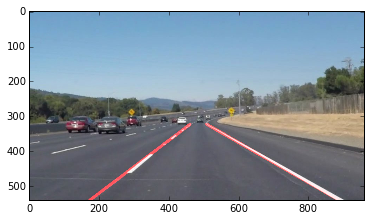

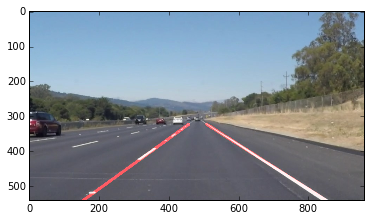

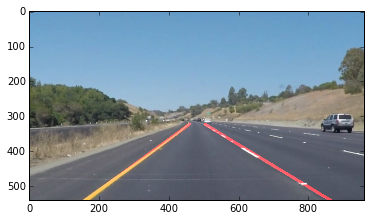

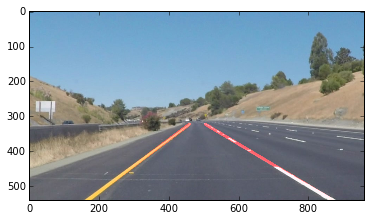

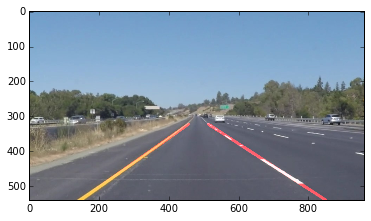

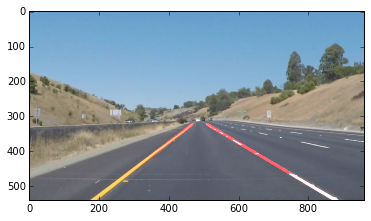

In [2]:
test_images_paths = ["test_images/" + f for f in os.listdir("test_images/")]
for test_image_path in test_images_paths:
    # reset memory (i.e. previously found lanes)
    lanes = {'left': {'x1': 0., 'y1': 0., 'x2': 0., 'y2': 0.},'right': {'x1': 0., 'y1': 0., 'x2': 0., 'y2': 0.}}
    # detect and plot lanes
    test_image = mpimg.imread(test_image_path)
    output_image = process_image(test_image)
    plt.imshow(output_image)
    plt.show()

## 3 - Test on videos
We then run the pipeline on the test video

In [3]:
# reset memory (i.e. previously found lanes)
lanes = {'left': {'x1': 0., 'y1': 0., 'x2': 0., 'y2': 0.},'right': {'x1': 0., 'y1': 0., 'x2': 0., 'y2': 0.}}
# detect lanes on the Test video
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 32.02it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 4.34 s, sys: 1.05 s, total: 5.4 s
Wall time: 7.6 s


## 4 - Reflections

There has been a lot of parameter tuning, especially for the Hough transform part.  
Another important aspect has been to filter between lines belonging to the right lane, left lane or other so that only lines belonging to a lane are considered.  
To finish, the 'memory' (i.e. averaging previously found lanes with current one appeared crucial in order to have smooth output and to be sure to always detect lanes.  
The result seems satisfying yet really taillored for this very specific configuration: this method may not work with a different video angle for example.

Another approach to make this lane lines detector less problem-specific  would be not to apply any mask but to cluster lanes found by the Hough transform, rather than filter them with hard-coded slopes intervals.  
Yet, even in this case, using a time-average of previous lanes (or a 'memory') would be needed in order to reduce noise and to be sure to detect something.

## 5 - Optional challenge
Running the pipeline over the Challenge video

In [4]:
# reset memory (i.e. previously found lanes)
lanes = {'left': {'x1': 0., 'y1': 0., 'x2': 0., 'y2': 0.},'right': {'x1': 0., 'y1': 0., 'x2': 0., 'y2': 0.}}
# detect lanes on the Challenge video
challenge_output = 'challenge_output.mp4'
clip1 = VideoFileClip("challenge.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4


100%|██████████| 251/251 [00:16<00:00, 15.50it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output.mp4 

CPU times: user 9.27 s, sys: 2.31 s, total: 11.6 s
Wall time: 17.7 s
